# ДЗ2 Анна Головина группа БКЛ213

*в некоторых ячейках код может выглядеть неожиданно крупным по количеству строк, но это все из-за форматирования по pep8*

Чтобы в дальнейшем не искать нужные ячейки с импортом нужных модулей, прописываю в первой же ячейке все необходимые импорты. Здесь модули, которые нужны для всех заданий.

In [52]:
import gensim
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk import tokenize
from nltk.tokenize import wordpunct_tokenize, sent_tokenize
import numpy as np
import os
from pymorphy2 import MorphAnalyzer
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')
import wikipedia
import zipfile36
%matplotlib inline

# Первое задание

Я решила взять 15 книг Солженицына (все, какие нашла на *lib.ru* и какие были крупнее рассказа).

В папке на своем рабочем столе, где лежат скачанные файлы с книгами, циклом вытаскиваю текст из каждого файла.

Токенизация происходит по предложениям. Обрабатывая каждое предложение, собираю список лемм, и при этом слежу, чтобы это было именно слово, а не число или знак препинания, а также чтобы слово не входило в список стоп-слов (к сожалению, некоторые предлоги все равно остались, потому что stopwords в nltk.corpus включает далеко не всё). Список лемм объединяется, и все токены разделяются пробелами. Каждое предложение записывается в файл на новой строке.

Файл *"lemmas.txt"*, полученный в результате работы ячейки, содержит леммы по соответствующим предложениям (каждое с новой строки) без знаков препинания и прочих небуквенных строк, а также без служебных слов, входящих в список nltk.

Анализатор и стоп-слова выношу в отдельную ячейку, так как они понадобятся и при запуске ячеек из последующих заданий.

In [11]:
morph = MorphAnalyzer()
stop_words = set(stopwords.words("russian")) # депрессия, в списке есть некоторые предлоги

In [67]:
with open("lemmas.txt", "a+", encoding="UTF-8") as f:
    for book in os.listdir(r"C:\Users\AnAnG\Desktop\для дз"):
        with open(
            os.path.join(r"C:\Users\AnAnG\Desktop\для дз", book), "r", encoding="UTF-8"
        ) as b:
            text = tokenize.sent_tokenize(b.read())
            for sentence in text:
                f.write(
                    " ".join(
                        [
                            morph.parse(item)[0].normal_form
                            for item in wordpunct_tokenize(sentence)
                            if (item.isalpha() == True and item not in stop_words)
                        ]
                    )
                )
                f.write("\n")

In [1]:
with open("lemmas.txt", "r", encoding="UTF-8") as f:
    file = f.read().split(" ")
print(len(file))

651366


# Второе задание

Согласно требованиям задания, обучаю модель со следующими параметрами: размер вектора 300 (vector_size=300), минимальное количество вхождений 5 (min_count=5), окно 5 (window=5), количество итераций 50 (epochs=50). На печать выводится искомое количество слов.

In [68]:
data = gensim.models.word2vec.LineSentence("lemmas.txt")
model_sol = gensim.models.Word2Vec(
    data, vector_size=300, window=5, min_count=5, epochs=50
)
model_sol.init_sims(replace=True)
model_path = "sol.bin"
model_sol.wv.save_word2vec_format(model_path, binary=True)
print(len(model_sol.wv.key_to_index))

15341


Получили 15 341 слово (нормально в целом, хотя это, конечно, очень немного для 15 крупных книг). Я, если честно, ожидала около 100 000 или хотя бы 50 000.

Ищем и выводим на печать 10 ближайших к абстрактному понятию слов. Получаем красивый распакованный список.

In [71]:
print(*[token[0] for token in model_sol.wv.most_similar("война", topn=10)], sep="\n")

господство
армия
записываться
окружение
фронт
телевидение
литва
двухмесячный
германский
буржуазия


*Насколько ожидаем такой результат? есть ли неожиданные соседи?*

В целом, все слова ассоциативно соотносятся с концептом войны. Есть некоторые вопросы к словам "господство", "телевидение" и "двухмесячный". С первым, правда, можно предположить, что речь идет про неравенство в армии (например, в смысле дедовщина как господство одних над другими), со вторым можно предположить, что телевидение становилось основным источником информации о войне в произведениях Солженицына, а с третьим словом (которое кажется достаточно универсальным) можно допустить частое употребление в контексте остаточного срока службы в армии или чего-то подобного.

*Есть ли синонимы / антонимы в ближайших к слову?*

Антонимов самого слова я не обнаружила. С натяжкой синонимом можно считать "фронт", но это скорее не синоним а лексема из коннотативного ряда. сли рассматривать полученный список, среди них я не вижу ярких синонимов или антонимов.

*Говорит ли это что-то о самом корпусе?*

Судя по полученному списку, ярко прослеживается временная принадлежность текстов. Среди перечисленных лексем указаны не только универсальные атрибуты войны или ассоциативные концепты, близкие войне, но и слова наподобие "буржуазия", "германский". То есть токены явно указывают на раннюю советскую эпоху.

Ищем и выводим на печать 10 ближайших к имени героя слов.

In [72]:
print(*[token[0] for token in model_sol.wv.most_similar("матрёна", topn=10)], sep="\n")

старуха
фаддей
горница
золовка
изба
коза
ефим
тётя
игнатич
горшков


*Насколько ожидаем такой результат? есть ли неожиданные соседи?*

Результат вполне ожидаемый, всё собственно указывает на героиню рассказа "Матрёнин двор" (других Матрён у Солженицына нет). Указаны очень часто упоминающиеся в контексте жизни Матрёны соседи, родственники, друзья. Указаны токены, которые всегда входят в цитаты относительно художественных деталей (интерьерных, например), всегда фигурирующих рядом с Матрёной. Если рассматривать результат, несколько абстрагируясь от содержания текста, можно сделать вывод, что к имени одного героя достаточно близки имена других героев (возможно, они часто упоминаются вместе или автору важно обратить внимание на взаимодействие героев, а не на окружающие их детали).

*Есть ли синонимы / антонимы в ближайших к слову?*

Антонимов самого имени (если так вообще можно сказать) снова нет. Ну как бы с натяжкой Фаддея можно отнести, потому что в рассказе он антагонист, но это уже привлечение контекста рассказа, антонимов в строгом смысле нет. То же самое с синонимами: они чисто контекстные, связанные с анализом конкретного текста (например, в каком-то смысле "старуха" - синоним, но только при наличии знания, что Матрёна в рассказе старая женщина). В списке слова будто не являются друг другу ни антонимами, ни синонимами.

*Говорит ли это что-то о самом корпусе?*

Имя Матрёна концентрирует лексику из одного конкретного текста и выдает вполне ожидаемые результаты, что уже было сказано ранее. Мне кажется, именно для описания свойств всего корпуса этот пример не очень репрезентативен.

Ищем и выводим на печать 10 ближайших к двум антонимам слов.

In [70]:
print(
    *[
        token[0]
        for token in model_sol.wv.most_similar(positive=["хороший", "плохой"], topn=10)
    ],
    sep="\n"
)

жребий
пешка
придурочий
дорожить
пастух
верный
обмануть
дурной
завершить
безвыходный


*Насколько ожидаем такой результат? есть ли неожиданные соседи?*

Есть, конечно, вопросы к словам "безвыходный", "придурочий" и "дорожить". Сложно сказать, почему они попали в эту выборку. Хотя про слово "придурочий" можно предположить, что в корпусе фигурируют контрастные описания героев с такой характеристикой (придурочий в смысле юродивый (положительные коннотации) и придурочий в смысле странный или безумный (негативные коннотации)). Остальные слова в целом можно ассоциировать с приведенными антонимами.

*Есть ли синонимы / антонимы в ближайших к слову?*

Антонимы я не нашла, синонимами в списке могут быть в определенном контексте "придурочий" и "дурной".

*Говорит ли это что-то о самом корпусе?*

В произведениях Солженицына присутствуют образы (например, "пешка"), которые можно ассоциировать с приведенными антонимами, а значит, рассматривать в противоположном смысле. Необычно, что достаточно часто в списке встречаются глаголы (я скорее ожидала существительные или другие прилагательные). Значит, произведения Солженицына, возможно больше построены на предикативных единицах.

Ищем лишнее слово в ряду "радость-горе-страсть-тоска". Ожидаю, что лишним будет слово "радость", потому что все остальные слова скорее про негативный эмоциональный фон или скорее про яркие эмоции.

In [73]:
model_sol.wv.doesnt_match("радость горе страсть тоска".split())

'тоска'

Ура, модель думает так же, как я, результат соответствует ожиданиям.

# Третье задание

Код из конспектов не работает и всё время выдает ошибку, так что пришлось дополнить его. Я добавила распаковщик zip-файлов (модуль *zipfile36*) и распаковала модель, которую предварительно скачала. Вроде, работает нормально.

In [15]:
with zipfile36.ZipFile("183.zip", "r") as zf:
    zf.extract("model.bin", ".")

model = gensim.models.KeyedVectors.load_word2vec_format("model.bin", binary=True)

Посмотрим, насколько модель в целом адекватна. Взяла пример из дз (пропорция с королем и королевой).

In [74]:
print(
    model.most_similar(
        positive=["король_NOUN", "королева_NOUN"], negative=["мужчина_NOUN"]
    )[0][0]
)

королева_ADV


Есть, конечно, вопросы, например, почему "королева" - это наречие. Но это оставим, главное, что само слово то, которое нужно.

Теперь посмотрим, что модель будет выдавать относительно других пропорций. Ожидаю, что *тюрьма - свобода + счастье = горе* (ну или что-то вроде того).

In [75]:
print(
    model.most_similar(
        positive=["тюрьма_NOUN", "счастье_NOUN"], negative=["свобода_NOUN"]
    )[0][0]
)

несчастье_NOUN


Ура, все сработало примерно так, как я и ожидала.

### Визуализация на названиях животных

Для визуализации использовала код из конспектов, поменяв список слов.
Удивляет только то, что две птицы из списка (дятел и голубь) расположены достаточно далеко друг от друга, хотя единственные в списке птицы вроде должны быть ближе друг к другу, чем к млекопитающим. Напротив, вполне ожидаемо, что кошка расположена рядом с крысой, потому что это наиболее очевидный образ (кошка как охотник на крыс). Баран тоже достаточно ожидаемо удален от других животных, но не очень понятно, почему ближе всего к нему голубь, а не кошка или крыса (как кластер животных, которые могут сосуществовать в деревенском хозяйстве, например).

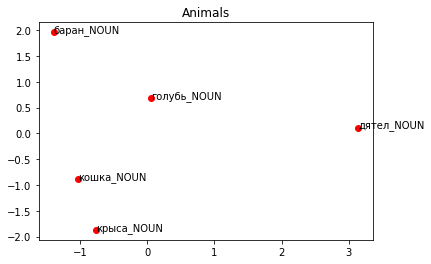

In [90]:
words = ["кошка_NOUN", "баран_NOUN", "голубь_NOUN", "дятел_NOUN", "крыса_NOUN"]
X = model[words]

pca = PCA(n_components=2)
coords = pca.fit_transform(X)

plt.scatter(coords[:, 0], coords[:, 1], color='red')
plt.title('Animals')

for i, word in enumerate(words):
    plt.annotate(word, xy=(coords[i, 0], coords[i, 1]))
plt.show()

### Визуализация на абстрактных понятиях

*здесь и далее нет пояснений по поводу ожиданий от результата, так как графики были уже сделаны, и затем в дз появилось примечание, что нужно сделать лишь один вариант на выбор, а графики удалять было уже жалко.*

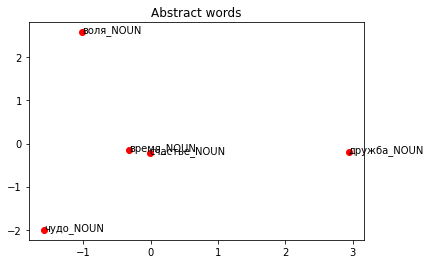

In [91]:
words = ["счастье_NOUN", "воля_NOUN", "время_NOUN", "чудо_NOUN", "дружба_NOUN"]
X = model[words]

pca = PCA(n_components=2)
coords = pca.fit_transform(X)

plt.scatter(coords[:, 0], coords[:, 1], color='red')
plt.title('Abstract words')

for i, word in enumerate(words):
    plt.annotate(word, xy=(coords[i, 0], coords[i, 1]))
plt.show()

### Визуализация на многозначных словах

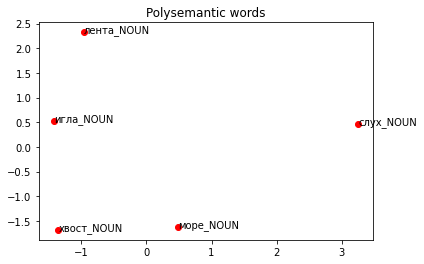

In [92]:
words = ["лента_NOUN", "игла_NOUN", "хвост_NOUN", "слух_NOUN", "море_NOUN"]
X = model[words]

pca = PCA(n_components=2)
coords = pca.fit_transform(X)

plt.scatter(coords[:, 0], coords[:, 1], color='red')
plt.title('Polysemantic words')

for i, word in enumerate(words):
    plt.annotate(word, xy=(coords[i, 0], coords[i, 1]))
plt.show()

Далее я выбрала рандомное предложение из какой-то книги Солженицына. Циклом прохожусь по каждому слову (итерируемый объект то есть список получается в результате токенизации). Сначала идет проверка, работаем мы со словом или какой-то небуквенной строкой (небуквенные игнорируем, они нам не нужны). Далее проверяем, служебное ли это слово. Если да, то просто плюсуем к строке, которая и будет новым предложением (new_sample), если нет, то надо распарсить с помощью pymorphy и добавить частеречный тег. 

Первый вывод на печать (первая ячейка) - список токенов с частеречными тегами . Поскольку модель НКРЯ и pymorphy пользуются разными тегами, надо поменять их (теги pymorphy на теги НКРЯ). Чтобы их поменять, надо понять, чем они различаются, так что на печать вывожу все токены, которые не являются служебными словами, в виде форматированных строк.

In [85]:
sample = "И еще то достоинство у ночных арестов, что ни соседние дома, ни городские улицы не видят, скольких увезли за ночь."
new_sample = ""

for token in wordpunct_tokenize(sample):
    if token.isalpha() == True:
        token = morph.parse(token.lower())[0]
        if token.normal_form not in stop_words:
            token = f"{token.normal_form}_{token.tag.POS}"
            print(token)

ещё_ADVB
достоинство_NOUN
ночной_ADJF
арест_NOUN
соседний_ADJF
дом_NOUN
городской_ADJF
улица_NOUN
видеть_VERB
сколько_NUMR
увезти_VERB
ночь_NOUN


**Здесь дублируется код из предыдущей ячейки, но так сделано специально, потому что без этого посмотреть вывод тегов в адекватном виде без смешивания с другими выводами цикла было бы затруднительно.**

Значит, поменять надо три тега: ADVB, ADJF, NUMR. Меняю с помощью .replace(). Дальше как по коду в предыдущих ячейках ищем ближайшее к данному слово, и кладем его в переменную alternative. Дальше отрезаем нижнее подчеркивание и частеречный тег (строка короткая, так что можно просто срез до индекса нижнего подчеркивания). Наконец, все это богатство приплюсовать к строчке с новыми токенами в виде форматированной строки с пробелом в конце. Готово!

In [89]:
new_sample = ""
sample = "И еще то достоинство у ночных арестов, что ни соседние дома, ни городские улицы не видят, скольких увезли за ночь."

for token in wordpunct_tokenize(sample):
    if token.isalpha() == True:
        token = morph.parse(token.lower())[0]
        if token.normal_form not in stop_words:
            token = f"{token.normal_form}_{token.tag.POS}"
            token = (
                token.replace("ADVB", "ADV")
                .replace("ADJF", "ADJ")
                .replace("NUMR", "NUM")
            )
            alternative = model.most_similar(positive=[token], topn=1)[0][0] # здесь уже токен в нормальном виде
            alternative = alternative[: alternative.index("_")]
            new_sample += f"{alternative} " # чтобы слова не слиплись, пробел после нового полученного токена в форматированной строке
        elif token.normal_form in stop_words:
            new_sample += f"{token.normal_form} "
print(new_sample)

и еще то достоинство у утренний арестовывать что ни соседний дома ни городской бульвар не увидать сколько увозить за вечер 


Получилось предложение в лемматизированном виде. Если переформулировать по-человечески, получится нечто следующее:
*И еще то достоинство у утренних арестов, что ни соседние дома, ни городские бульвары не увидят, сколько увезли за вечер.*
Замен получилось не очень много, они в целом даже адекватные, хотя если задуматься над предложением, звучит странно (если аресты утренние при чем тут то, сколько людей увезли за вечер?). То есть в целом нормально, но не идеально.


### 3.2 TF-IDF

Сразу пропишу функцию в начале кода, чтобы она не мешалась далее и не появилась позже, чем ячейка, в которой эта функция понадобится.

In [96]:
def get_top_tf_idf_words(tfidf_vector, feature_names, top_n):
    sorted_nzs = np.argsort(tfidf_vector.data)[:-(top_n+1):-1]
    return feature_names[tfidf_vector.indices[sorted_nzs]]

Подготавливаю векторайзер по коду из конспекта и добавляю указанные в задании дополнительные параметры.

In [83]:
vectorizer = TfidfVectorizer(
    analyzer="word", stop_words=stop_words, ngram_range=(1, 3), min_df=3
)

Для сбора статей использую модуль wikipedia (других модулей, где красиво распарсили википедию, к сожалению, не знаю), потому что вручную все это копировать достаточно странно. Сначала необходимо настроить язык, потому что по дефолту модуль лезет в английскую википедию.

В переменную articles_for_analysis собираю списки названий подходящих мне статей (их 49, потому что чем больше, тем лучше). Функция search() как раз позволяет искать статьи по ключевым словам. Я просто выбрала рандомные слова, относящиеся к разным областям знаний и поместила их в список key_words. Список articles_for_analysis собран через сложение, потому что иначе там получается список со вложенными списками, что достаточно неудобно, а через плюсики можно сразу получить слитный единообразный список.

Наконец, открываю на дозапись файл *"wiki_collection.txt"* и вставляю туда тексты статей (каждая статья отделяется от предыдущей переносом строки). Поскольку далее я буду работать с данными в переменных, будем считать, что запись в файл нужна для проверки того, как работает код, а также на случай если в другом коде вдруг понадобятся полученные данные (то есть такая стратегическая заготовка материалов).

In [84]:
wikipedia.set_lang("ru")  # википедия, понятное дело, русская

key_words = ["сражение", "город", "язык", "режиссер", "роман", "уравнение", "вещество"]
articles_for_analysis = []

for word in key_words:
    articles_for_analysis += wikipedia.search(word, results=7)

with open("wiki_collection.txt", "a+", encoding="UTF-8") as f:
    articles_listed = [
        wikipedia.page(f"{item}").content for item in articles_for_analysis
    ]
    f.write("\n".join(articles_listed))

Лемматизирую тексты статей так же, как показано в конспектах.

In [93]:
articles_preprocessed = []
for article in articles_listed:
    list_of_tokens = wordpunct_tokenize(article)
    lemmatized = " ".join(
        [
            morph.parse(item)[0].normal_form
            for item in list_of_tokens
            if item.isalpha() == True
        ]
    )
    articles_preprocessed.append(lemmatized)

Далее в игру вступает собственно метрика TF-IDF, подготавливаем матрицу (в ней лемматизированные тексты статей).

In [94]:
tfidf = vectorizer.fit_transform(articles_preprocessed)

Далее наконец печатаю ключевые слова. Поскольку статьи крупные, а по 10 ключевым словам не всегда понятно, о какой именно статье идет речь, печатаю ту часть статьи, которая находится до первой точки. Иногда это оборванное предложение, но важно, что видно заголовок статьи.

In [97]:
feature_names = np.array(vectorizer.get_feature_names())

for i, article in enumerate(articles_listed):
    vector = tfidf[i, :]
    words = get_top_tf_idf_words(vector, feature_names, 10)
    print(article.split(".")[0], words, sep="\n")

Сражение — столкновение двух армий или флотов (значительных масс войск или сил), приведшее к более или менее существенной перемене обстановки на театре военных действий или театре войны, и определившее участь целой операции или кампании
['сражение' 'военный' 'армия' 'бой' 'битва' 'словарь' 'сила' 'кампания'
 'генеральный' 'операция']
Бороди́нское сраже́ние, или Бороди́нская би́тва (во французской истории — битва у Москвы-реки, фр
['генерал' 'армия' 'сражение' 'русский' 'наполеон' 'корпус' 'кутузов'
 'войско' 'русский армия' 'французский']
Сражение под Малоярославцем (фр
['наполеон' 'армия' 'сражение' 'француз' 'кутузов' 'русский' 'октябрь'
 'дорога' 'русский армия' 'смоленск']
Сражéние под Прóхоровкой — сражение между бронетанковыми частями германской и советской армий в ходе оборонительной фазы Курской битвы
['дивизия' 'июль' 'корпус' 'гвардейский' 'армия' 'советский' 'сражение'
 'наступление' 'го' 'фланг']
Га́нгутское сраже́ние (швед
['флот' 'корабль' 'русский' 'отряд' 'сражение' 'по

Визуализируем вектора.

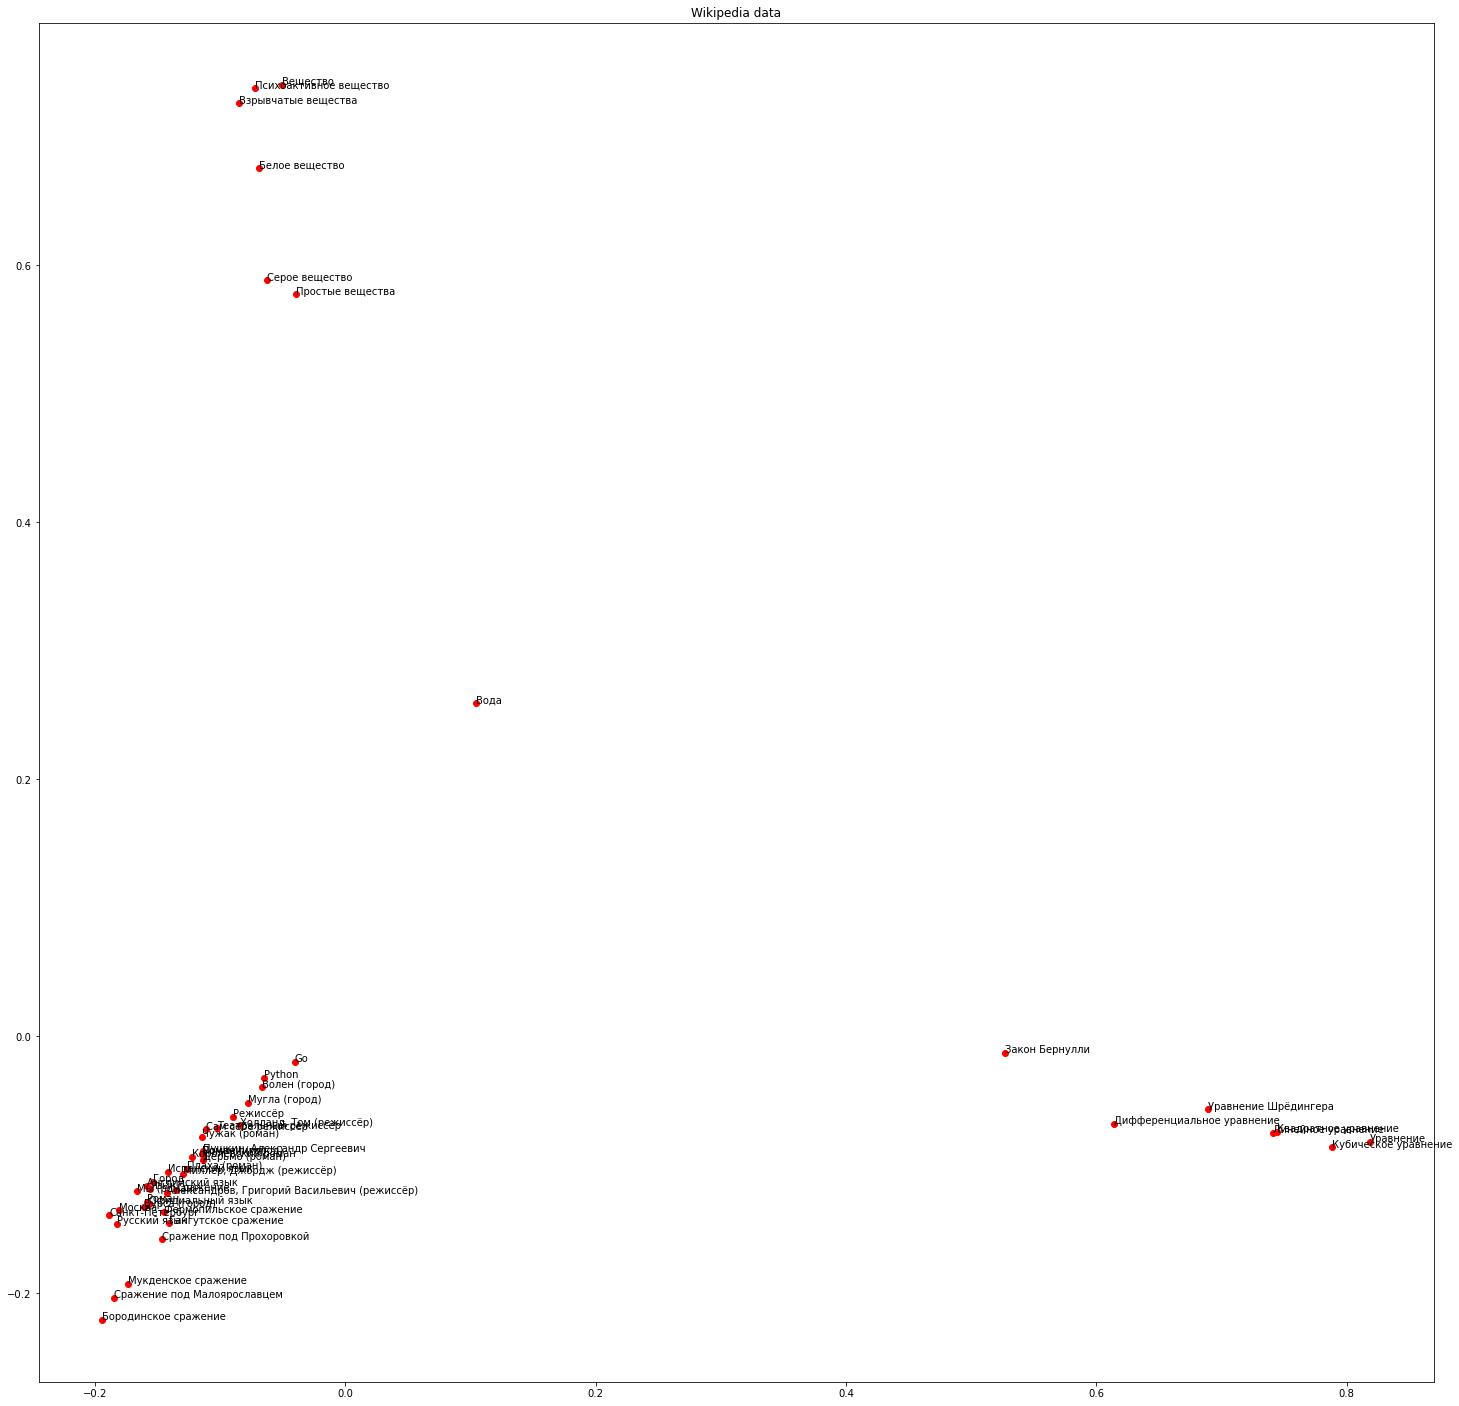

In [98]:
pca = PCA(n_components=2)
coords = pca.fit_transform(tfidf.toarray())

plt.figure(figsize=(25,25))
plt.scatter(coords[:, 0], coords[:, 1], color='red')
plt.title('Wikipedia data')

for i, article in enumerate(articles_for_analysis):
    plt.annotate(article, xy=(coords[i, 0], coords[i, 1]))
plt.show()

Поскольку статей получилось крайне много, пришлось поменять размер графика, чтобы названия были видны в принципе. Размер установила 25x25, нижний левый кластер все равно выглядит достаточно "слипшимся", но это лучше, чем черное облако названий, полученное до изменения размера.

Теперь оценим кластеризацию. Вообще достаточно странно, что в один (нижний слева) кластер попали тексты про химию, литературу, города, кино и исторические сражения. Именно эта часть визуализации кажется не очень убедительной. Однако в правом нижнем углу графика достаточно хорошо кластеризовались математические тексты. Одно остается непонятным: почему так далеко от них находится текст про закон Бернулли. Также хорошо кластеризовались тексты в левом верхнем углу графика. Там сосредоточены тексты про химию, причем биологические субстанции сгруппированы между собой теснее, они как бы отделены от химических субстанций, то есть показана разница между двумя разными смыслами слова "вещество", и это прямо порадовало.

То есть в целом визуализация средняя: местами очень хорошая, местами работает максимально странно.